<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning Para Aplicações Biomédicas</font>
## <font color='blue'>Projeto 6</font>
## <font color='blue'>Interações Proteína-Proteína (PPIs) com Graph Neural Networks</font>

<img src="imagens/grafo.png" width="600" />

As Interações Proteína-Proteína (PPIs) referem-se às conexões físicas e funcionais que ocorrem entre duas ou mais proteínas dentro de uma célula. Essas interações são essenciais para praticamente todos os processos biológicos, incluindo a regulação de funções celulares, sinalização, metabolismo e a formação de estruturas celulares.

De forma simples, imagine que as proteínas são peças de um quebra-cabeça que se encaixam entre si para executar tarefas específicas. Quando duas ou mais proteínas se ligam, elas podem ativar, inibir ou modificar uma à outra, permitindo que a célula responda adequadamente a diferentes estímulos e mantenha seu funcionamento correto. A compreensão das PPIs é importante, pois desvios nessas interações podem levar a doenças, como o câncer ou outras condições genéticas.

## Pacotes Python Usados no Projeto

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

O procedimento de instalação de pacotes e dependências está no arquivo LEIAME.txt

https://networkx.org/

In [2]:
#!pip install -q networkx

In [3]:
# Imports
import time
import torch
import scipy
import sklearn
import matplotlib
import networkx as nx
import numpy as np
import torch.nn.functional as F
from torch import nn
from scipy import sparse as sp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Funções Para Carga dos Dados no Formato de Grafo

In [5]:
# Define a função que carrega os dados a partir de um arquivo edgelist
def dsa_carrega_dados(filename = 'yeast.edgelist'):
    
    # Lê o arquivo edgelist e cria um grafo usando a biblioteca NetworkX
    graph = nx.read_edgelist(filename)
    
    # Gera a matriz de adjacência a partir do grafo
    adjacency = nx.adjacency_matrix(graph)
    
    # Retorna o grafo e a matriz de adjacência
    return graph, adjacency

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Uma matriz de adjacência é uma representação matemática de um grafo que descreve as conexões entre seus nós. Em um grafo, os nós representam entidades e as arestas (conexões) representam relacionamentos entre esses nós. A matriz de adjacência é uma forma de representar essas conexões de maneira tabular, usando uma matriz.

In [6]:
# Define a função que faz um subsample do grafo, limitando o número de nós
def dsa_subsample_graph(graph, max_nodes = 1000):
    
    # Seleciona um subconjunto aleatório de nós do grafo e cria um subgrafo com esses nós
    graph = graph.subgraph(np.random.choice(graph.nodes(), max_nodes, replace = False)).copy()
    
    # Mantém apenas o maior componente conectado do subgrafo
    graph = graph.subgraph(sorted(nx.connected_components(graph), key = len, reverse = True)[0]).copy()
    
    # Remove nós isolados (sem arestas) do subgrafo
    graph.remove_nodes_from(list(nx.isolates(graph)))
    
    # Gera a matriz de adjacência a partir do subgrafo
    adjacency = nx.adjacency_matrix(graph)
    
    # Retorna o subgrafo e a matriz de adjacência
    return graph, adjacency

In [7]:
# Define a função que obtém o índice das arestas a partir da matriz de adjacência
def dsa_get_edge_index(adjacency):
    
    # Mantém apenas a parte superior da matriz de adjacência para evitar duplicidade de arestas
    adjacency = sp.triu(adjacency)
    
    # Retorna as coordenadas dos elementos não nulos (as arestas) na matriz de adjacência
    return np.stack(adjacency.nonzero(), axis = 0)

## Carregando os Dados

In [8]:
# Extrai grafo e matriz de adjacências
graph, adjacency = dsa_carrega_dados('yeast.edgelist')

In [9]:
# Cada nó é uma proteína
graph.nodes

NodeView(('YLR418C', 'YOL145C', 'YOR123C', 'YBR279W', 'YML069W', 'YGL244W', 'YGL207W', 'YER164W', 'YIL035C', 'YOR061W', 'YGL019W', 'YOR039W', 'YDL209C', 'YDR364C', 'YMR213W', 'YLR117C', 'YGR278W', 'YGL128C', 'YBR065C', 'YJR050W', 'YPL213W', 'YLL036C', 'YGL120C', 'YAL032C', 'YPL151C', 'YHR165C', 'YER029C', 'YGR074W', 'YLR147C', 'YPR101W', 'YKL173W', 'YDR416W', 'YGR129W', 'YKL095W', 'YKR022C', 'YLR424W', 'YNL245C', 'YIR010W', 'YBR211C', 'YDR254W', 'YPL018W', 'YLR381W', 'YJR135C', 'YAL034W-A', 'YDR383C', 'YPL233W', 'YGR179C', 'YJL091C', 'YHR019C', 'YCL061C', 'YOR254C', 'YDR170C', 'YJR100C', 'YNL124W', 'YLR175W', 'YJL072C', 'YDR013W', 'YOL146W', 'YDR489W', 'YDL140C', 'YIL021W', 'YGR116W', 'YGR186W', 'YGR005C', 'YPL129W', 'YML010W', 'YOR151C', 'YPL063W', 'YMR203W', 'YDR288W', 'YEL019C', 'YLR007W', 'YDL105W', 'YLR383W', 'YOL034W', 'YDR365C', 'YDR299W', 'YJL033W', 'YER127W', 'YOR310C', 'YHR196W', 'YGR145W', 'YFR003C', 'YER133W', 'YKL193C', 'YGR002C', 'YJL081C', 'YLR384C', 'YOR244W', 'YDR190C'

In [10]:
# A matriz de adjacência indica os relacionamentos entre os nós
# É uma matriz densa com valor 1 indicando se existe relação entre os nós
adjacency.data.view()

array([1, 1, 1, ..., 1, 1, 1], shape=(1062675,))

In [11]:
# Cria uma amostra de até 1000 nós
graph, adjacency = dsa_subsample_graph(graph, max_nodes = 1000)

In [12]:
# Obtém o índice de arestas
edge_index = dsa_get_edge_index(adjacency)

In [13]:
print(graph)

Graph with 911 nodes and 12854 edges


In [14]:
# Extrai o número de nós e número de arestas
N_NODES = adjacency.shape[0]
N_EDGES = edge_index.shape[1]

In [15]:
N_NODES

911

In [16]:
N_EDGES

12854

## Data Splitting de Grafos

Agora, vamos dividir os dados em conjuntos de treinamento, validação e teste. 

Para criar os conjuntos de validação e teste, selecionaremos algumas arestas existentes para criar exemplos positivos e, em seguida, amostraremos algumas arestas ausentes (verificando se elas não estão no grafo) para ter exemplos negativos.

Então, para cada conjunto:

1. Amostramos X% das arestas como exemplos positivos.
2. Criamos exemplos negativos selecionando pares de nós que não estão conectados no grafo original, tantos quantos tivermos arestas positivas.

Finalmente, o conjunto de treinamento consistirá no restante das arestas. Para evitar o treinamento nas arestas de validação e teste, também construímos uma máscara para a matriz de adjacência que indicará se usamos uma determinada aresta durante o treinamento.

No final teremos essencialmente isso em cada amostra:

- Aresta está no grafo (classe positiva)
- Aresta não está no grafo (classe negativa)

E assim vamos transformar o problema em aprendizado supervisionado para classificação binária. O modelo GNN vai ser treinado com dados de arestas e nós e então avaliaremos o modelo com arestas positivas e negativas (ou seja, arestas que estão ou não no grafo).

In [17]:
# Porcentagem de arestas a serem usadas para o conjunto de validação e teste
TEST_EDGE_RATIO = 0.1  

Veja a descrição completa da função abaixo no videobook do Capítulo 14 do curso.

In [18]:
# Define a função que divide as arestas do grafo em conjuntos de treino, validação e teste,
# criando ainda classe positiva e negativa
def dsa_split_graph_edges(adj, edge_index, test_edge_ratio = TEST_EDGE_RATIO):

    # Calcula o número de arestas para validação e teste com base na proporção especificada
    n_valid = n_test = int(N_EDGES * test_edge_ratio)
    
    # Separa as arestas de validação
    valid_edges = edge_index[:, :n_valid]
    
    # Separa as arestas de teste
    test_edges = edge_index[:, n_valid:n_valid + n_test]
    
    # Define o conjunto de arestas de treino com o restante das arestas
    train_edges = edge_index[:, n_valid + n_test:]

    # Inicializa a lista para armazenar arestas negativas
    neg_edge = []
    
    # Define o número de arestas negativas a serem geradas
    num_neg = n_valid + n_test
    
    # Gera arestas negativas aleatórias até alcançar o número necessário
    while len(neg_edge) < num_neg:
        
        i, j = np.random.randint(0, N_NODES, size = (2,))
        
        # Verifica se os nós são diferentes, não estão conectados e se a aresta já não foi gerada
        if i != j and adj[i, j] == 0 and [i, j] not in neg_edge:
            neg_edge.append([i, j])
    
    # Converte a lista de arestas negativas de validação em array e a transpõe
    valid_edges_neg = np.array(neg_edge[:n_valid]).T
    
    # Converte a lista de arestas negativas de teste em array e a transpõe
    test_edges_neg = np.array(neg_edge[n_valid:]).T

    # Cria a matriz de adjacência para o conjunto de treino a partir das arestas de treino
    adj_train = sp.csr_matrix((np.ones(train_edges.shape[1]), train_edges), shape = adj.shape)
    
    # Ajusta a matriz de adjacência para incluir as arestas na direção oposta e remove autoconexões
    adj_train = adj_train + adj_train.T - sp.diags(adj_train.diagonal(), dtype = int)
    
    # Recalcula os índices das arestas de treino com base na nova matriz de adjacência
    train_edges = dsa_get_edge_index(adj_train)
    
    # Cria uma máscara para indicar as arestas de treino (true para treino, false para validação e teste)
    train_mask = np.ones(adj_train.shape, dtype = bool)
    
    # Atualiza a máscara de treino para remover as arestas de validação, teste e suas contrapartes negativas
    # também remove a direção reversa
    for edges in [valid_edges, valid_edges_neg, test_edges, test_edges_neg]:
        i += (edges[0] == edges[1]).sum()
        train_mask[edges[0], edges[1]] = False
        train_mask[edges[1], edges[0]] = False  

    # Retorna a matriz de adjacência de treino, as arestas de treino, a máscara de treino,
    # e os conjuntos de arestas de validação, validação negativa, teste e teste negativo
    return adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg

**Arestas Positivas**: São as conexões que existem no grafo original, representando interações reais entre nós. No contexto de aprendizado de máquina em grafos, estas são as conexões que o modelo deve aprender a prever corretamente.

**Arestas Negativas**: São conexões que não existem no grafo. Elas são geradas aleatoriamente entre pares de nós que não estão conectados no grafo original. Essas arestas são usadas para ensinar o modelo a reconhecer e evitar previsões de conexões inexistentes.

In [19]:
# Gera as amostras
adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg = dsa_split_graph_edges(adjacency, edge_index, TEST_EDGE_RATIO)


In [20]:
print(f"Divisão dos Edges (Arestas) em:\n treino: {train_edges.shape[1]}\n validação: {valid_edges.shape[1]}\n teste: {test_edges.shape[1]}")

Divisão dos Edges (Arestas) em:
 treino: 10284
 validação: 1285
 teste: 1285


In [21]:
# Amostras positivas de treino
n_pos_edge = adj_train[train_mask].sum()

In [22]:
# Amostras negativas de treino
n_neg_edge = (1 - adj_train.todense())[train_mask].sum()

In [23]:
# Calculamos a taxa das arestas positivas
# Usaremos isso como peso para compensar o desequilíbrio
pos_weight = n_neg_edge / n_pos_edge  

In [24]:
print(f"Taxa de Edges Negativo/Positivo: {pos_weight:.2f}")

Taxa de Edges Negativo/Positivo: 39.31


## Visualizando os Grafos de Treino, Validação e Teste

Vamos visualizar uma parte dos dados do grafo. Note que amostramos nós aleatoriamente para esta visualização, então é possível que acabemos com mais de um único componente conectado, mesmo que o grafo completo tenha apenas um.

In [25]:
# Número de nós a serem mantidos para a visualização
N = 200  

In [26]:
nodelist = np.random.permutation(graph.nodes())[:N]

O que a expressão acima faz:

- Embaralha a lista de nós do grafo (graph.nodes()).
- Seleciona os primeiros 𝑁 nós da lista embaralhada.

In [27]:
# Cria o sub-grafo
subgraph = graph.subgraph(nodelist).copy()

In [28]:
# Remove auto-loops para visualização
subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  

In [29]:
# Remove nós isolados para visualização
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))  

In [30]:
print(subgraph)

Graph with 184 nodes and 757 edges


In [31]:
# A expressão abaixo é usada para calcular as posições dos nós de um grafo (subgraph) para fins de visualização, 
# utilizando o algoritmo Spring Layout, que é uma forma comum de desenhar grafos de maneira esteticamente agradável
pos = nx.spring_layout(subgraph, iterations = 100)

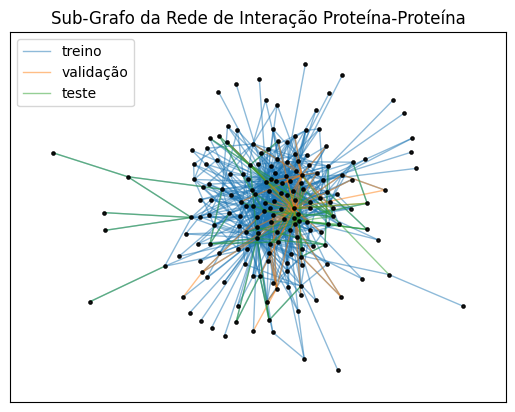

In [32]:
# Cria uma figura e um eixo para o gráfico (aqui é o gráfico que vai mostrar o grafo)
fig, ax = plt.subplots(1, 1)

# Define o título do gráfico
ax.set_title('Sub-Grafo da Rede de Interação Proteína-Proteína')

# Itera sobre os conjuntos de arestas (treino, validação e teste) e suas respectivas cores
for edge_set, color in [(train_edges, 'C0'), (valid_edges, 'C1'), (test_edges, 'C2')]:
    
    # Obtém a lista de arestas correspondentes ao conjunto atual
    edgelist = subgraph.edges(np.array(graph.nodes())[edge_set[0]])
    
    # Desenha o subgrafo com as arestas selecionadas, utilizando a cor especificada
    nx.draw_networkx(subgraph, 
                     pos, 
                     edgelist = edgelist, 
                     ax = ax, 
                     with_labels = False, 
                     node_size = 5, 
                     node_color = 'black', 
                     edge_color = color, 
                     width = 1., 
                     alpha = 0.5)

# Adiciona uma legenda ao gráfico para diferenciar as arestas de treino, validação e teste
ax.legend([Line2D([], 
                  [], 
                  color = c, 
                  linewidth = 1., 
                  alpha = 0.5) for c in ('C0', 'C1', 'C2')], ['treino', 'validação', 'teste']);

## Preparando os Dados

Agora, podemos preparar os dados para o PyTorch. O modelo toma como entrada os embeddings de nós e a matriz de adjacência, e irá prever arestas.

Note que este conjunto de dados não tem nenhum embedding de nós, as únicas informações disponíveis são as interações existentes (as arestas). Então, criaremos manualmente os embeddings para cada nó.

In [33]:
# Define a função que converte uma matriz esparsa do scipy para um tensor esparso do PyTorch
def dsa_sparse_array_to_tensor(adj):
    
    # Converte uma matriz esparsa do scipy para um tensor esparso do PyTorch.
    # Converte a matriz esparsa para o formato COO (Coordinate list)
    adj = adj.tocoo()
    
    # Retorna um tensor esparso do PyTorch criado a partir dos dados da matriz COO
    return torch.sparse_coo_tensor(
        
        # As coordenadas das arestas (linhas e colunas)
        torch.LongTensor(np.vstack((adj.row, adj.col))),  
        
        # Os valores não nulos da matriz
        torch.FloatTensor(adj.data), 
        
        # O tamanho original da matriz
        torch.Size(adj.shape))

In [34]:
# Converte os dados em tensores PyTorch
data = {
    'adj_train': dsa_sparse_array_to_tensor(adj_train).to_dense(), # matriz de adjacência do conjunto de treinamento
    'train_edges': torch.LongTensor(train_edges),                  # índices de arestas no conjunto de treinamento
    'train_mask': torch.BoolTensor(train_mask),                    # máscara booleana de arestas no conjunto de treinamento
    'valid_edges': torch.LongTensor(valid_edges),                  # índices de arestas no conjunto de validação
    'valid_edges_neg': torch.LongTensor(valid_edges_neg),          # índices de arestas negativas no conjunto de validação
    'test_edges': torch.LongTensor(test_edges),                    # índices de arestas no conjunto de teste
    'test_edges_neg': torch.LongTensor(test_edges_neg),            # índices de arestas negativas no conjunto de teste
}

In [35]:
# Incorpora os nós como vetores one-hot. Isso cria a matriz de embeddings!
D_NODES = N_NODES  
data['x_train'] = torch.eye(N_NODES)

In [36]:
# Print 
for key, value in data.items():
    print(f"Matriz: {key}, Shape: {value.shape}")

Matriz: adj_train, Shape: torch.Size([911, 911])
Matriz: train_edges, Shape: torch.Size([2, 10284])
Matriz: train_mask, Shape: torch.Size([911, 911])
Matriz: valid_edges, Shape: torch.Size([2, 1285])
Matriz: valid_edges_neg, Shape: torch.Size([2, 1285])
Matriz: test_edges, Shape: torch.Size([2, 1285])
Matriz: test_edges_neg, Shape: torch.Size([2, 1285])
Matriz: x_train, Shape: torch.Size([911, 911])


In [37]:
# Checagem das dimensões
# Se houver problema uma mensagem será impressa. Caso contrário, tudo pronto para a modelagem.
num_pos_edges = data["train_edges"].shape[1] + data["valid_edges"].shape[1] + data["test_edges"].shape[1]
assert num_pos_edges == N_EDGES, "O número total de arestas nas divisões deve corresponder ao número original de arestas"

# Continuaremos no Próximo Capítulo!

In [38]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [39]:
#%watermark -v -m

In [40]:
#%watermark --iversions

# Fim